## Load the dataset


In [1]:
import pandas as pd
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False)

data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [2]:
data_text = data[:300000][['headline_text']]

data_text.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [6]:
data_text['index'] = data_text.index

documents = data_text
documents.head()

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


In [7]:
len(documents)

300000

## Data Preprocessing

In [8]:
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np

H:\Anaconda3\envs\main\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :

        if token not in stopwords.words('english') and len(token) > 3:
            
            result.append(lemmatize_stemming(token))
    return result

In [13]:
document_num = 4310
doc_sample = documents[documents['index'] == document_num].values[0][0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['rain', 'helps', 'dampen', 'bushfires']


Tokenized and lemmatized document: 
['rain', 'help', 'dampen', 'bushfir']


In [20]:
processed_docs = documents['headline_text'].map(preprocess)

In [21]:
processed_docs[:10]

0                [decid, communiti, broadcast, licenc]
1                       [fire, wit, must, awar, defam]
2               [call, infrastructur, protect, summit]
3                          [staff, aust, strike, rise]
4                 [strike, affect, australian, travel]
5                   [ambiti, olsson, win, tripl, jump]
6               [antic, delight, record, break, barca]
7    [aussi, qualifi, stosur, wast, four, memphi, m...
8                [aust, address, secur, council, iraq]
9                             [australia, lock, timet]
Name: headline_text, dtype: object

## Get a BOW Dict from data

In [22]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.items():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 communiti
2 decid
3 licenc
4 awar
5 defam
6 fire
7 must
8 wit
9 call
10 infrastructur


## filter the dict

In [24]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)

## Convert document into BOW format by doc2bow

In [26]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [31]:
bow_doc_4310 = bow_corpus[document_num]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 76 ("bushfir") appears 1 time.
Word 112 ("help") appears 1 time.
Word 476 ("rain") appears 1 time.
Word 3580 ("dampen") appears 1 time.


## TF-IDF on our document set 


In [37]:
tfidf = gensim.models.TfidfModel(bow_corpus)

In [38]:
corpus_tfidf = tfidf[bow_corpus]

In [39]:
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.5959813347777092), (1, 0.39204529549491984), (2, 0.48531419274988147), (3, 0.5055461098578569)]


## Running LDA using Bag of Words data

In [40]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=10, 
                                       id2word = dictionary, 
                                       passes = 2, 
                                       workers=2)

In [41]:
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.040*"warn" + 0.026*"polic" + 0.015*"victim" + 0.013*"crash" + 0.013*"stand" + 0.012*"investig" + 0.011*"hick" + 0.011*"threat" + 0.011*"shoot" + 0.010*"blue"


Topic: 1 
Words: 0.044*"govt" + 0.038*"plan" + 0.034*"council" + 0.021*"urg" + 0.015*"back" + 0.014*"water" + 0.014*"group" + 0.014*"health" + 0.013*"fund" + 0.010*"servic"


Topic: 2 
Words: 0.025*"water" + 0.021*"push" + 0.020*"reject" + 0.018*"power" + 0.017*"farmer" + 0.017*"drought" + 0.016*"price" + 0.015*"govt" + 0.014*"offer" + 0.014*"home"


Topic: 3 
Words: 0.038*"kill" + 0.026*"attack" + 0.025*"crash" + 0.020*"road" + 0.019*"chang" + 0.017*"die" + 0.017*"driver" + 0.014*"communiti" + 0.013*"polic" + 0.013*"dead"


Topic: 4 
Words: 0.032*"polic" + 0.030*"find" + 0.022*"miss" + 0.022*"fire" + 0.014*"probe" + 0.014*"search" + 0.013*"blaze" + 0.013*"school" + 0.012*"forc" + 0.011*"call"


Topic: 5 
Words: 0.036*"charg" + 0.030*"face" + 0.028*"court" + 0.022*"polic" + 0.022*"jail" + 0.021*"death" + 0.020

## Topic coherence

In [44]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.24392424055124354


In [65]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -6.5238873274397875


## find the optimal number of topics

In [70]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [71]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

<Figure size 640x480 with 1 Axes>

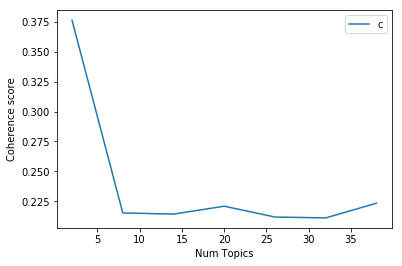

In [72]:
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#seem 

## Running LDA using TF-IDF ##

In [45]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=10, 
                                             id2word = dictionary, 
                                             passes = 2, 
                                             workers=4)

In [46]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.007*"titl" + 0.007*"break" + 0.006*"hill" + 0.006*"troop" + 0.005*"world" + 0.005*"firefight" + 0.005*"gold" + 0.004*"aussi" + 0.004*"coast" + 0.004*"final"


Topic: 1 Word: 0.007*"rudd" + 0.006*"polic" + 0.004*"chase" + 0.004*"ship" + 0.004*"lake" + 0.004*"traffic" + 0.004*"afghanistan" + 0.004*"flood" + 0.004*"council" + 0.004*"spot"


Topic: 2 Word: 0.018*"polic" + 0.016*"kill" + 0.014*"charg" + 0.012*"murder" + 0.012*"miss" + 0.010*"search" + 0.010*"death" + 0.010*"find" + 0.009*"court" + 0.009*"attack"


Topic: 3 Word: 0.010*"rise" + 0.008*"rate" + 0.007*"farm" + 0.007*"wind" + 0.006*"water" + 0.005*"govt" + 0.005*"plan" + 0.005*"interest" + 0.005*"council" + 0.004*"rat"


Topic: 4 Word: 0.009*"timor" + 0.006*"east" + 0.006*"iraq" + 0.005*"open" + 0.005*"talk" + 0.005*"govt" + 0.005*"govern" + 0.004*"say" + 0.004*"south" + 0.004*"iemma"


Topic: 5 Word: 0.010*"health" + 0.009*"govt" + 0.007*"urg" + 0.007*"council" + 0.007*"plan" + 0.006*"fund" + 0.006*"liber" + 0.

In [48]:
from gensim.models import CoherenceModel

coherence_model_lda_idf = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_model_lda_idf = coherence_model_lda_idf.get_coherence()
print('\nCoherence Score: ', coherence_model_lda_idf)


Coherence Score:  0.33426617536044023


## classifying sample document using LDA Bag of Words model

In [49]:
#original Text of sample document 4310
processed_docs[document_num]

['rain', 'help', 'dampen', 'bushfir']

In [50]:
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: tup[1], reverse=True):
    print("\nScore: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.619993269443512	 Topic: 0.025*"water" + 0.021*"push" + 0.020*"reject" + 0.018*"power" + 0.017*"farmer"

Score: 0.21999461948871613	 Topic: 0.020*"make" + 0.019*"elect" + 0.014*"decis" + 0.014*"inquiri" + 0.013*"final"

Score: 0.02000802382826805	 Topic: 0.032*"polic" + 0.030*"find" + 0.022*"miss" + 0.022*"fire" + 0.014*"probe"

Score: 0.020001571625471115	 Topic: 0.040*"warn" + 0.026*"polic" + 0.015*"victim" + 0.013*"crash" + 0.013*"stand"

Score: 0.020001430064439774	 Topic: 0.044*"govt" + 0.038*"plan" + 0.034*"council" + 0.021*"urg" + 0.015*"back"

Score: 0.020000431686639786	 Topic: 0.022*"mine" + 0.021*"minist" + 0.017*"record" + 0.015*"market" + 0.014*"world"

Score: 0.020000357180833817	 Topic: 0.020*"aust" + 0.018*"iraq" + 0.016*"labor" + 0.015*"talk" + 0.014*"howard"

Score: 0.020000185817480087	 Topic: 0.020*"lead" + 0.016*"test" + 0.013*"time" + 0.011*"say" + 0.011*"take"

Score: 0.02000010386109352	 Topic: 0.038*"kill" + 0.026*"attack" + 0.025*"crash" + 0.020*"road

In [52]:
lda_model[bow_corpus[document_num]]

[(0, 0.020001575),
 (1, 0.020001432),
 (2, 0.61999243),
 (3, 0.020000106),
 (4, 0.020010116),
 (5, 0.020000001),
 (6, 0.020000434),
 (7, 0.21999337),
 (8, 0.020000359),
 (9, 0.020000188)]

In [53]:
sorted(lda_model[bow_corpus[document_num]], key=lambda tup: tup[1], reverse=True)

[(2, 0.61999303),
 (7, 0.2199943),
 (4, 0.020008579),
 (0, 0.020001572),
 (1, 0.02000143),
 (6, 0.020000432),
 (8, 0.020000357),
 (9, 0.020000186),
 (3, 0.020000104),
 (5, 0.02)]

In [54]:
lda_model.print_topic(index, 10)

'0.036*"charg" + 0.030*"face" + 0.028*"court" + 0.022*"polic" + 0.022*"jail" + 0.021*"death" + 0.020*"accus" + 0.019*"sydney" + 0.019*"closer" + 0.018*"murder"'

## classifying sample document using LDA TF-IDF model##

In [95]:
for index, score in sorted(lda_model_tfidf[bow_corpus[document_num]], key=lambda tup: tup[1], reverse=True):
    print("\nScore: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))


Score: 0.8199732899665833	 Topic: 0.022*"crash" + 0.010*"die" + 0.010*"fire" + 0.009*"polic" + 0.009*"blaze"

Score: 0.02000579424202442	 Topic: 0.009*"water" + 0.009*"govt" + 0.008*"nuclear" + 0.006*"plan" + 0.006*"hick"

Score: 0.02000509388744831	 Topic: 0.010*"rise" + 0.008*"rate" + 0.007*"farm" + 0.007*"wind" + 0.006*"water"

Score: 0.02000296860933304	 Topic: 0.010*"health" + 0.009*"govt" + 0.007*"urg" + 0.007*"council" + 0.007*"plan"

Score: 0.020002806559205055	 Topic: 0.007*"rudd" + 0.006*"polic" + 0.004*"chase" + 0.004*"ship" + 0.004*"lake"

Score: 0.02000265382230282	 Topic: 0.025*"closer" + 0.006*"govt" + 0.006*"servic" + 0.006*"plan" + 0.006*"doctor"

Score: 0.02000240422785282	 Topic: 0.018*"polic" + 0.016*"kill" + 0.014*"charg" + 0.012*"murder" + 0.012*"miss"

Score: 0.020002134144306183	 Topic: 0.007*"tsunami" + 0.005*"pipelin" + 0.005*"doubt" + 0.005*"sailor" + 0.004*"swan"

Score: 0.02000153250992298	 Topic: 0.009*"timor" + 0.006*"east" + 0.006*"iraq" + 0.005*"open" 

## Testing model on unseen document ##

In [90]:
unseen_document = "My name is Patrick."

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: tup[1], reverse=True):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.3666805624961853	 Topic: 0.044*"govt" + 0.038*"plan" + 0.034*"council" + 0.021*"urg" + 0.015*"back"
Score: 0.36664098501205444	 Topic: 0.040*"warn" + 0.026*"polic" + 0.015*"victim" + 0.013*"crash" + 0.013*"stand"
Score: 0.03333942964673042	 Topic: 0.020*"make" + 0.019*"elect" + 0.014*"decis" + 0.014*"inquiri" + 0.013*"final"
Score: 0.03333901986479759	 Topic: 0.022*"mine" + 0.021*"minist" + 0.017*"record" + 0.015*"market" + 0.014*"world"
Score: 0.03333333134651184	 Topic: 0.020*"aust" + 0.018*"iraq" + 0.016*"labor" + 0.015*"talk" + 0.014*"howard"
Score: 0.03333333134651184	 Topic: 0.020*"lead" + 0.016*"test" + 0.013*"time" + 0.011*"say" + 0.011*"take"
Score: 0.03333332762122154	 Topic: 0.025*"water" + 0.021*"push" + 0.020*"reject" + 0.018*"power" + 0.017*"farmer"
Score: 0.03333332762122154	 Topic: 0.038*"kill" + 0.026*"attack" + 0.025*"crash" + 0.020*"road" + 0.019*"chang"
Score: 0.03333332762122154	 Topic: 0.032*"polic" + 0.030*"find" + 0.022*"miss" + 0.022*"fire" + 0.014*"pr